In [39]:
#calling initial necessities
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler

In [40]:
# pulling in data

SPCSV = pd.read_csv('^GSPC.csv')
SPCSV.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-05,2101.679932,2108.780029,2090.409912,2099.929932,2099.929932,4051890000
1,2015-11-06,2098.600098,2101.909912,2083.739990,2099.199951,2099.199951,4369020000
2,2015-11-09,2096.560059,2096.560059,2068.239990,2078.580078,2078.580078,3882350000
3,2015-11-10,2077.189941,2083.669922,2069.909912,2081.719971,2081.719971,3821440000
4,2015-11-11,2083.409912,2086.939941,2074.850098,2075.000000,2075.000000,3692410000


In [41]:
#adjusting date to make it friendly

SPCSV["Date"] = pd.to_datetime(SPCSV.Date,format="%Y-%m-%d")
SPCSV.index = SPCSV['Date']


In [42]:
# Assign the data to X and y (opening and closing values)
# Note: Sklearn requires a two-dimensional array of values
# so we use reshape to create this

X = SPCSV.Date.values.reshape(-1, 1)
y = SPCSV.Close.values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)
X

Shape:  (1259, 1) (1259, 1)


array([['2015-11-05T00:00:00.000000000'],
       ['2015-11-06T00:00:00.000000000'],
       ['2015-11-09T00:00:00.000000000'],
       ...,
       ['2020-11-02T00:00:00.000000000'],
       ['2020-11-03T00:00:00.000000000'],
       ['2020-11-04T00:00:00.000000000']], dtype='datetime64[ns]')

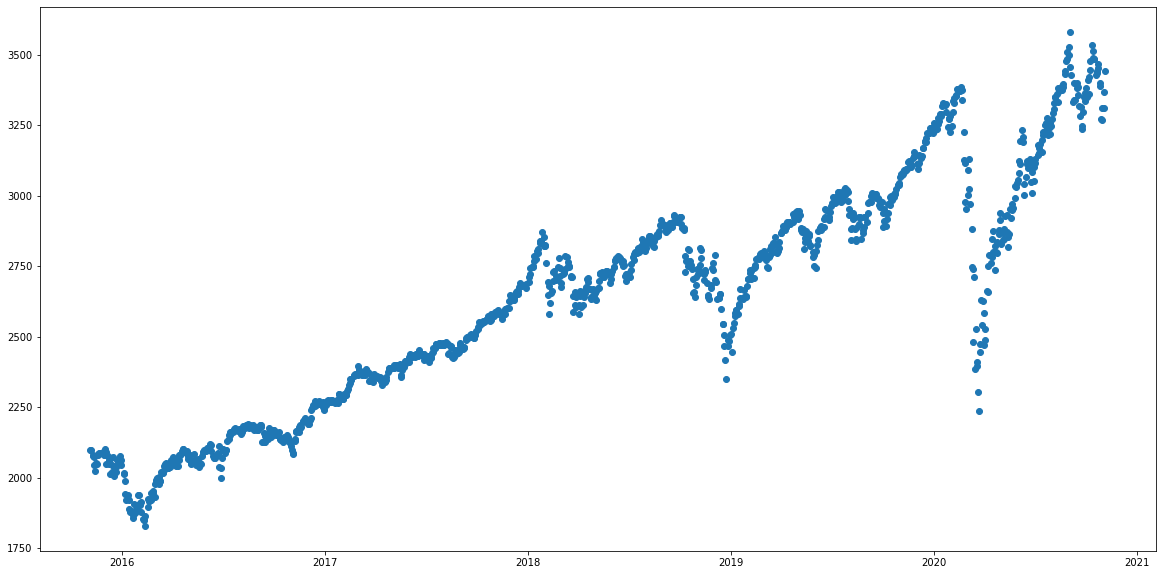

In [43]:
# Plot the data
plt.scatter(X, y)


In [44]:
# Create the model and fit the model to the data

from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [45]:
#fitting model to data
model.fit(X, y)


LinearRegression()

In [46]:
# Print the coefficient and the intercept for the model

print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

Weight coefficients:  [[8.26580976e-15]]
y-axis intercept:  [-9975.46863596]


In [62]:
x_min = np.array([[X.min()]])
x_max = np.array([[X.max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")
y_min = np.array([[y.min()]])
y_max = np.array([[y.max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")

Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-04T00:00:00.000000000']]
Min X Value: [['2015-11-05T00:00:00.000000000']]
Max X Value: [['2020-11-04T00:00:00.000000000']]


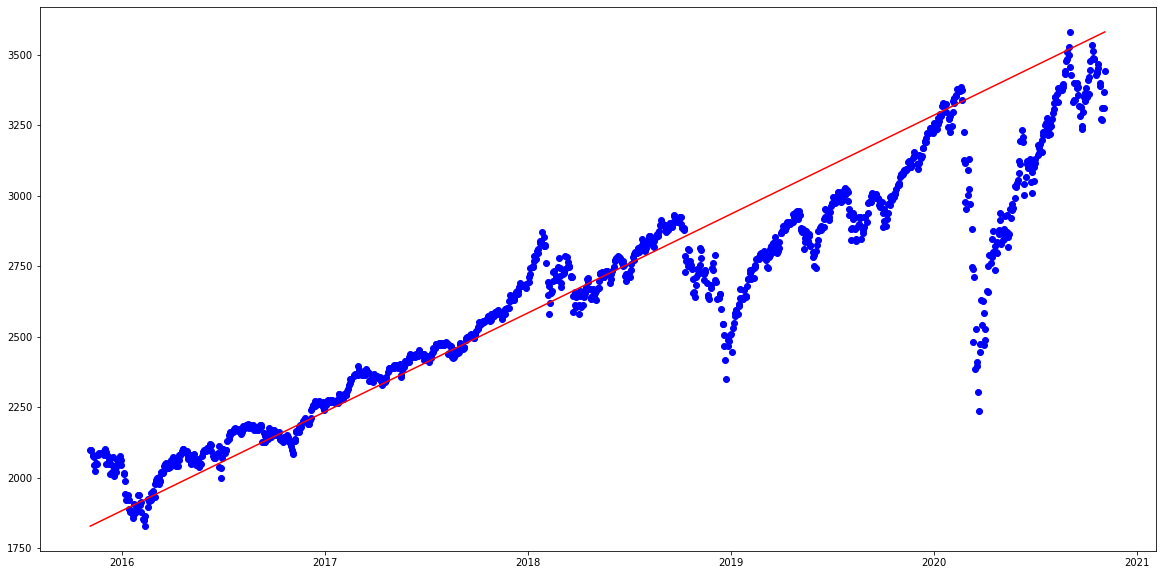

In [63]:
plt.scatter(X, y, c='blue')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')


In [64]:
#skimming down table to essentials
data = SPCSV.sort_index(ascending=True,axis=0)
new_SPCSV = pd.DataFrame(index=range(0,len(SPCSV)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_SPCSV["Date"][i] = data['Date'][i]
    new_SPCSV["Close"][i]= data["Close"][i]

new_SPCSV.head()

,Date,Close
0,2015-11-05 00:00:00,2099.93
1,2015-11-06 00:00:00,2099.2
2,2015-11-09 00:00:00,2078.58
3,2015-11-10 00:00:00,2081.72
4,2015-11-11 00:00:00,2075


In [65]:
#normalizing data

scaler = MinMaxScaler(feature_range = (0,1))
final_SPCSV = new_SPCSV.values

train_SPCSV = final_SPCSV[0:987,:]
valid_SPCSV = final_SPCSV[987:,:]

In [66]:
new_SPCSV.index = new_SPCSV.Date
new_SPCSV.drop("Date",axis=1, inplace=True)
new_SPCSV.head()

,Close
Date,
2015-11-05,2099.93
2015-11-06,2099.2
2015-11-09,2078.58
2015-11-10,2081.72
2015-11-11,2075


In [111]:
scaler = MinMaxScaler(feature_range=(0,1))
#importing datetime to make this work
#import datetime as dt
#from datetime import datetime
#final_SPCSV = final_SPCSV["Date"].astype(str)
scaled_SPCSV = scaler.fit_transform(new_SPCSV)
print(scaled_SPCSV)
#this would not work when i tried using final_SPCSV as i was struggling to convert timestamp, but i don't think
#that affects the values, it was just a cleaner

[[0.1546159 ]
 [0.15419919]
 [0.14242825]
 ...
 [0.84552674]
 [0.87916144]
 [0.92156452]]


In [112]:
X_train_SPCSV, y_train_SPCSV = [],[]

for i in range(60,len(train_SPCSV)):
    X_train_SPCSV.append(scaled_SPCSV[i-60:i,0])
    y_train_SPCSV.append(scaled_SPCSV[i,0])

In [113]:
X_train_SPCSV, y_train_SPCSV = np.array(X_train_SPCSV),np.array(y_train_SPCSV)

X_train_SPCSV = np.reshape(X_train_SPCSV,(X_train_SPCSV.shape[0],X_train_SPCSV.shape[1],1))

In [114]:
#building LSTM model

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences = True, input_shape=(X_train_SPCSV.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


In [115]:
#run time
inputs_SPCSV = new_SPCSV
inputs_SPCSV=new_SPCSV[len(new_SPCSV)-len(valid_SPCSV)-60:].values
inputs_SPCSV=inputs_SPCSV.reshape(-1,1)
inputs_SPCSV=scaler.transform(inputs_SPCSV)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(X_train_SPCSV,y_train_SPCSV,epochs=20,batch_size=1,verbose=2)

Epoch 1/20
927/927 - 26s - loss: 0.0018
Epoch 2/20
927/927 - 25s - loss: 8.1657e-04
Epoch 3/20
927/927 - 29s - loss: 5.1977e-04
Epoch 4/20
927/927 - 25s - loss: 4.5567e-04
Epoch 5/20
927/927 - 24s - loss: 3.5111e-04
Epoch 6/20
927/927 - 23s - loss: 3.6241e-04
Epoch 7/20
927/927 - 23s - loss: 3.1043e-04
Epoch 8/20
927/927 - 22s - loss: 2.7876e-04
Epoch 9/20
927/927 - 22s - loss: 2.6672e-04
Epoch 10/20
927/927 - 23s - loss: 2.6177e-04
Epoch 11/20
927/927 - 28s - loss: 2.9530e-04
Epoch 12/20
927/927 - 25s - loss: 2.5034e-04
Epoch 13/20
927/927 - 26s - loss: 2.5686e-04
Epoch 14/20
927/927 - 25s - loss: 2.3881e-04
Epoch 15/20
927/927 - 24s - loss: 2.7245e-04
Epoch 16/20
927/927 - 25s - loss: 2.4240e-04
Epoch 17/20
927/927 - 24s - loss: 2.4837e-04
Epoch 18/20
927/927 - 24s - loss: 2.5487e-04
Epoch 19/20
927/927 - 27s - loss: 2.3677e-04
Epoch 20/20
927/927 - 28s - loss: 2.1952e-04


In [116]:
#sampling to make predictions
X_test=[]
for i in range(60,inputs_SPCSV.shape[0]):
    X_test.append(inputs_SPCSV[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [139]:
#saving model and csv
modelprediction = pd.DataFrame(predicted_closing_price, columns=['predicted_closing_price']).to_csv('modelprediction.csv')
lstm_model.save("saved_model.h5")

/Applications/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


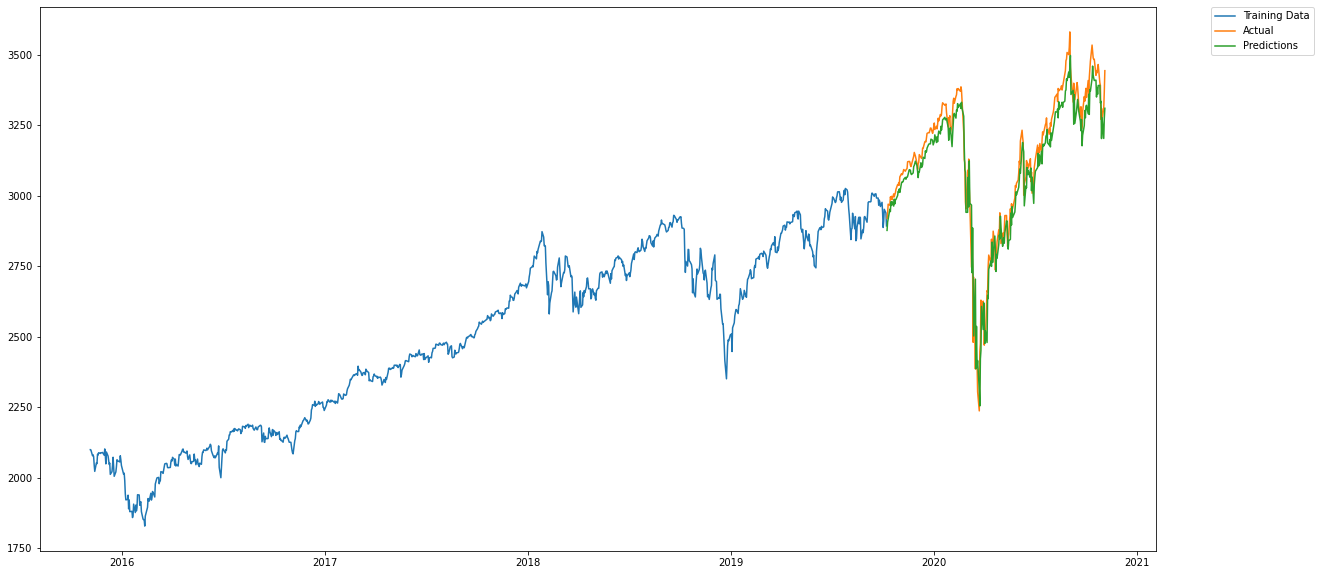

In [135]:
#visualization of prediction vs actual
train_data=new_SPCSV[:987]
valid_data=new_SPCSV[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"], label="Training Data")
plt.plot(valid_data["Close"], label="Actual")
plt.plot(valid_data['Predictions'], label = "Predictions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [136]:
#scoring model
from math import sqrt
#print(inputs_SPCSV)
#print(X_test)
#print(predicted_closing_price)
#print(valid_data["Close"])
rmse = sqrt(mean_squared_error(valid_data["Close"], predicted_closing_price))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 71.922
